In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import keras
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, Normalizer, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from sklearn.preprocessing import PowerTransformer
from keras.regularizers import l1_l2

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

2024-06-12 19:12:49.933215: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 19:12:50.551844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
volatility_df = pd.read_csv('volatility_df.csv', 
                     parse_dates=['Date'], index_col='Date')

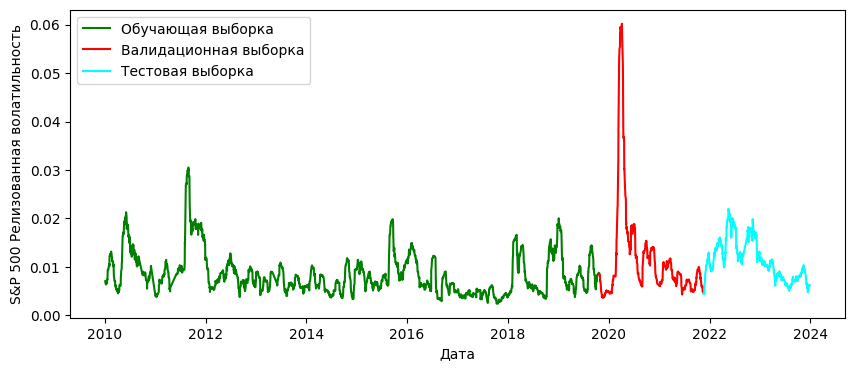

In [3]:
plot_values = volatility_df['Realized_Volatility']

train_size = int(len(plot_values) * 0.7)
val_size = int(len(plot_values) * 0.15)
test_size = len(plot_values) - train_size - val_size

train_sample = plot_values.iloc[:train_size]
val_sample = plot_values.iloc[train_size:train_size + val_size]
test_sample = plot_values.iloc[train_size + val_size:]

plt.figure(figsize=(10, 4))
plt.plot(train_sample, color='green', label='Обучающая выборка')
plt.plot(val_sample, color='red', label='Валидационная выборка')
plt.plot(test_sample, color='cyan', label='Тестовая выборка')
plt.xlabel('Дата')
plt.ylabel('S&P 500 Релизованная волатильность')
plt.legend()

plt.savefig('train_val_test.svg', format='svg', dpi=1200)

plt.show()

In [4]:
volatility_df = volatility_df[['Recovered_vol', 'Realized_Volatility']]

volatility_df = volatility_df.replace([0], 1e-6)

volatility_df = volatility_df / volatility_df.shift(1) - 1

lag = -5
volatility_df[f'Realized_Volatility_(t+{abs(lag)})'] = volatility_df['Realized_Volatility'].shift(lag)
volatility_df = volatility_df.dropna()
volatility_df.drop('Realized_Volatility', axis=1, inplace=True)
print(len(volatility_df))
volatility_df.head(10)

3357


,Recovered_vol,Realized_Volatility_(t+5)
Date,,
2010-01-05,-0.024188,0.031692
2010-01-06,0.001425,0.029962
2010-01-07,0.007015,-0.022161
2010-01-08,0.030061,0.046408
2010-01-11,0.030583,0.073188
2010-01-12,-0.037054,-0.011969
2010-01-13,0.161288,0.137014
2010-01-14,0.012751,0.125819
2010-01-15,-0.231002,0.002256


In [5]:
# Стандартизация, нормализация, замена выбросов медианой

values_clear = volatility_df.copy()

train_size = int(len(values_clear) * 0.7)
val_size = int(len(values_clear) * 0.15)
test_size = len(values_clear) - train_size - val_size

train = values_clear.iloc[:train_size]
val = values_clear.iloc[train_size:train_size + val_size]
test = values_clear.iloc[train_size + val_size:]

# Обучаем стандартизатор, нормализатор и изолейшн форест на тренировочных данных
transformer = PowerTransformer(method='yeo-johnson')
transformer.fit(train)
train_transformed = transformer.transform(train)

scaler = MinMaxScaler(feature_range=(1e-6, 1))
scaler.fit(train_transformed)
train_scaled = scaler.transform(train_transformed)

isolation_forest = IsolationForest(n_estimators=1000, contamination=0.01, random_state=42) # 0.01
isolation_forest.fit(train_scaled)

normalizer = Normalizer()
normalizer.fit(train_scaled)

# Применяем стандартизатор, нормализатор и изолейшн форест на тренировочных, валидационных и тестовых данных
train_isolation_forest = isolation_forest.predict(train_scaled)
train_normalized = normalizer.transform(train_scaled)

val_transformed = transformer.transform(val)
val_scaled = scaler.transform(val_transformed)
val_isolation_forest = isolation_forest.predict(val_scaled)
val_normalized = normalizer.transform(val_scaled)

test_transformed = transformer.transform(test)
test_scaled = scaler.transform(test_transformed)
test_isolation_forest = isolation_forest.predict(test_scaled)
test_normalized = normalizer.transform(test_scaled)

# Считаем метрику
train_values = np.median(train_normalized, axis=0)
val_values = np.median(val_normalized, axis=0)
test_values = np.median(test_normalized, axis=0)

# Заполняем выбросы медианой
train_normalized[train_isolation_forest == -1] = train_values
val_normalized[val_isolation_forest == -1] = val_values
test_normalized[test_isolation_forest == -1] = test_values

y_train = train_normalized[:, -1:]
y_train = np.squeeze(y_train)
X_train = np.delete(train_normalized, -1, axis=1)

y_val = val_normalized[:, -1:]
y_val = np.squeeze(y_val)
X_val = np.delete(val_normalized, -1, axis=1)

y_test = test_normalized[:, -1:]
y_test = np.squeeze(y_test)
X_test = np.delete(test_normalized, -1, axis=1)

# Reshape
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(2349, 1, 1) (2349,) (503, 1, 1) (503,) (505, 1, 1) (505,)


In [6]:
# LSTM

In [7]:
# custom_logcosh

penalty = 5
quantile_threshold = 75
quantile = tf.constant(np.percentile(y_train, quantile_threshold), dtype=tf.float32)

def custom_logcosh(y_true, y_pred):
    error = y_true - y_pred
    mask = tf.cast(y_true > quantile, tf.float32)
    weighted_error = error * (1 + penalty * mask * (y_true - quantile))
    return tf.reduce_sum(tf.math.log(tf.math.cosh(weighted_error)))

In [8]:
n_units = 4
dropout_rate = 0.0
recurrent_dropout_rate = 0.0
activation = 'tanh'
seed = 1
input_model = (X_train.shape[1], X_train.shape[2])

model = Sequential()

model.add(LSTM(
    n_units,
    activation=activation, 
    return_sequences=True,
    input_shape=input_model,
    recurrent_dropout=recurrent_dropout_rate,
    seed=seed,
))
model.add(Dropout(dropout_rate))

model.add(LSTM(
    n_units,
    activation=activation,
    return_sequences=True,
    recurrent_dropout=recurrent_dropout_rate,
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(LSTM(
    n_units,
    activation=activation,
    recurrent_dropout=recurrent_dropout_rate,
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(Dense(1))
model.add(Activation('linear'))

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=custom_logcosh) # keras.losses.log_cosh

history = model.fit(X_train,
                    y_train,
                    epochs=500,
                    batch_size=4,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    shuffle=False,
                    callbacks=[early_stopping])

# Предсказание значений на валидационной выборке
val_pred = model.predict(X_val)
print(f'MSE val: {mean_squared_error(y_val, val_pred):.4f}')
print(f'MAE val: {mean_absolute_error(y_val, val_pred):.4f}')
print(f'R2 val: {r2_score(y_val, val_pred):.4f}')
print(f'MAPE val: {mean_absolute_percentage_error(y_val, val_pred):.4f}')

# Предсказание значений на тестовой выборке
y_pred = model.predict(X_test)
print(f'MSE test: {mean_squared_error(y_test, y_pred):.4f}')
print(f'MAE test: {mean_absolute_error(y_test, y_pred):.4f}')
print(f'R2 test: {r2_score(y_test, y_pred):.4f}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_pred):.4f}')

Epoch 1/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9534 - val_loss: 0.7217
Epoch 2/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6312 - val_loss: 0.3187
Epoch 3/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2273 - val_loss: 0.0326
Epoch 4/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0198 - val_loss: 0.0059
Epoch 5/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 6/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 7/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 8/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 9/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067 - val_loss: 0.0057
Epoch 10/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 11/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 12/500
588/588 ━━━━━━━━━━━━━━━━━━━━

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 69/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 70/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 71/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 72/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 73/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 74/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 75/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 76/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 77/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 78/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 79/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 132/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.0134e-05 - val_loss: 6.0873e-05
Epoch 133/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.9515e-05 - val_loss: 6.0430e-05
Epoch 134/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.8892e-05 - val_loss: 6.0019e-05
Epoch 135/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.8284e-05 - val_loss: 5.9630e-05
Epoch 136/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.7672e-05 - val_loss: 5.9213e-05
Epoch 137/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.7064e-05 - val_loss: 5.8794e-05
Epoch 138/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.6465e-05 - val_loss: 5.8402e-05
Epoch 139/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.5869e-05 - val_loss: 5.7993e-05
Epoch 140/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.5274e-05 - val_loss: 5.7594e-05
Epoch 141/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.4677e-05 - val_loss: 5.7204e-05
Epoch 142/500
588/588 ━━━━━━━━

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.7647e-05 - val_loss: 3.9628e-05
Epoch 195/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.7214e-05 - val_loss: 3.9374e-05
Epoch 196/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.6777e-05 - val_loss: 3.9137e-05
Epoch 197/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.6346e-05 - val_loss: 3.8894e-05
Epoch 198/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5923e-05 - val_loss: 3.8669e-05
Epoch 199/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5494e-05 - val_loss: 3.8432e-05
Epoch 200/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5075e-05 - val_loss: 3.8203e-05
Epoch 201/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.4656e-05 - val_loss: 3.7986e-05
Epoch 202/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.4240e-05 - val_loss: 3.7738e-05
Epoch 203/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.3826e-05 - val_loss: 3.7537e-05
Epoch 204/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4651e-05 - val_loss: 1.9951e-05
Epoch 257/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4334e-05 - val_loss: 1.9388e-05
Epoch 258/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4011e-05 - val_loss: 1.8856e-05
Epoch 259/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3709e-05 - val_loss: 1.8283e-05
Epoch 260/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3399e-05 - val_loss: 1.7712e-05
Epoch 261/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3096e-05 - val_loss: 1.7164e-05
Epoch 262/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2794e-05 - val_loss: 1.6604e-05
Epoch 263/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2487e-05 - val_loss: 1.6057e-05
Epoch 264/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2195e-05 - val_loss: 1.5505e-05
Epoch 265/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1907e-05 - val_loss: 1.4958e-05
Epoch 266/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1

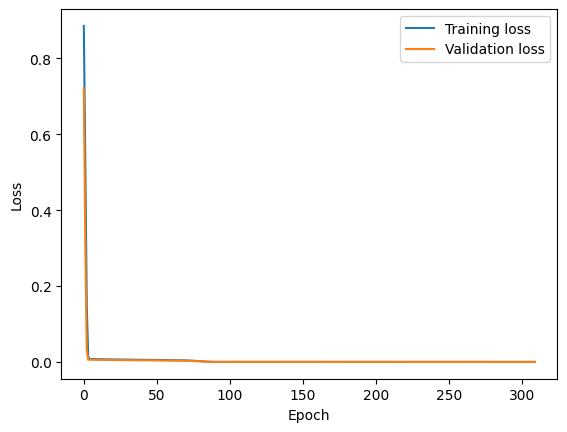

In [9]:
# График лосса

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots()
ax.plot(train_loss, label='Training loss')
ax.plot(val_loss, label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
# сохранение модели с помощью метода save()

# lstm_model_v1.keras - 1 признак Recovered_vol
model_filename = '/home/ranksjupyter/notebooks/Ranks/sector_models/vols_pred/lstm_model_v1.keras'
model.save(model_filename)

In [ ]:
model = tf.keras.models.load_model('lstm_model_v1.keras', custom_objects={'custom_logcosh': custom_logcosh})

# Get the configuration of the model
# config = model.get_config()
# config

In [ ]:
# Предсказание значений на валидационной выборке
val_pred = model.predict(X_val)
print(f'MSE val: {mean_squared_error(y_val, val_pred):.4f}')
print(f'MAE val: {mean_absolute_error(y_val, val_pred):.4f}')
print(f'R2 val: {r2_score(y_val, val_pred):.4f}')
print(f'MAPE val: {mean_absolute_percentage_error(y_val, val_pred):.4f}')

# Предсказание значений на тестовой выборке
y_pred = model.predict(X_test)
print(f'MSE test: {mean_squared_error(y_test, y_pred):.4f}')
print(f'MAE test: {mean_absolute_error(y_test, y_pred):.4f}')
print(f'R2 test: {r2_score(y_test, y_pred):.4f}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_pred):.4f}')

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_sample.index, y_test, label='Тестовая выборка', color='cyan', linewidth=1)
plt.plot(test_sample.index, y_pred, label='Предсказания на тестовой выборке', color='black', linewidth=1, linestyle='--')
plt.xlabel('Дата')
plt.ylabel('S&P 500 Реализованная волатильность \n после предобработки')
plt.legend()

plt.savefig('test_predictions.svg', format='svg', dpi=1000)

plt.show()

In [ ]:
# # Построение графика val выборки и прогнозов

# plt.figure(figsize=(10, 5))
# plt.plot(y_val, label='Validation data')
# plt.plot(val_pred, label='Validation Predictions')
# plt.title('Validation data and predictions')
# plt.xlabel('Samples')
# plt.ylabel('Values')
# plt.legend()
# plt.show()

In [10]:
# keras.losses.log_cosh

n_units = 4
dropout_rate = 0.0
recurrent_dropout_rate = 0.0
activation = 'tanh'
seed = 1
input_model = (X_train.shape[1], X_train.shape[2])

model = Sequential()

model.add(LSTM(
    n_units,
    activation=activation, 
    return_sequences=True,
    input_shape=input_model,
    recurrent_dropout=recurrent_dropout_rate,
    seed=seed,
))
model.add(Dropout(dropout_rate))

model.add(LSTM(
    n_units,
    activation=activation,
    return_sequences=True,
    recurrent_dropout=recurrent_dropout_rate,
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(LSTM(
    n_units,
    activation=activation,
    recurrent_dropout=recurrent_dropout_rate,
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(Dense(1))
model.add(Activation('linear'))

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=keras.losses.log_cosh) # keras.losses.log_cosh

history = model.fit(X_train,
                    y_train,
                    epochs=500,
                    batch_size=4,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    shuffle=False,
                    callbacks=[early_stopping])

# Предсказание значений на валидационной выборке
val_pred_log_cosh = model.predict(X_val)
print(f'MSE val: {mean_squared_error(y_val, val_pred_log_cosh):.4f}')
print(f'MAE val: {mean_absolute_error(y_val, val_pred_log_cosh):.4f}')
print(f'R2 val: {r2_score(y_val, val_pred):.4f}')
print(f'MAPE val: {mean_absolute_percentage_error(y_val, val_pred):.4f}')

# Предсказание значений на тестовой выборке
y_pred_log_cosh = model.predict(X_test)
print(f'MSE test: {mean_squared_error(y_test, y_pred_log_cosh):.4f}')
print(f'MAE test: {mean_absolute_error(y_test, y_pred_log_cosh):.4f}')
print(f'R2 test: {r2_score(y_test, y_pred_log_cosh):.4f}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_pred_log_cosh):.4f}')

Epoch 1/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2188 - val_loss: 0.1617
Epoch 2/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1385 - val_loss: 0.0653
Epoch 3/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0448 - val_loss: 0.0055
Epoch 4/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 5/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 11/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 12/500
588/588 ━━━━━━━━━━━━━━━━━━━━

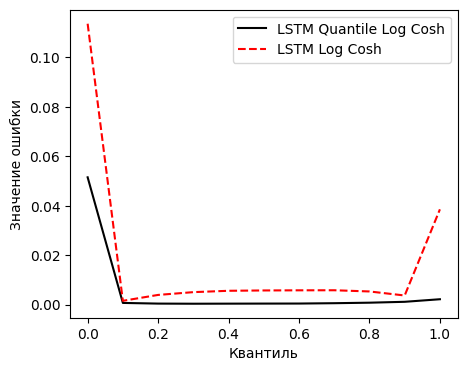

In [12]:
# LSTM quantile logcosh
quan = []
for q in np.arange(0, 1.1, 0.1):
    quantile_error = np.abs(np.quantile(y_test, q) - np.quantile(y_pred, q))
    quan.append(quantile_error)
quan_df = pd.DataFrame(quan, columns=['LSTM quantile logcosh'])
index = np.arange(0, len(quan_df)*0.1, 0.1)
quan_df.set_index(index, inplace=True)

# LSTM logcosh
quan_log_cosh = []
for q in np.arange(0, 1.1, 0.1):
    quantile_error = np.abs(np.quantile(y_test, q) - np.quantile(y_pred_log_cosh, q))
    quan_log_cosh.append(quantile_error)
    
quan_df_log_cosh = pd.DataFrame(quan_log_cosh, columns=['LSTM logcosh'])
index = np.arange(0, len(quan_df_log_cosh)*0.1, 0.1)
quan_df_log_cosh.set_index(index, inplace=True)

quan_df['LSTM logcosh'] = quan_df_log_cosh

plt.figure(figsize=(5, 4))
plt.plot(quan_df['LSTM quantile logcosh'], color='black', label='LSTM Quantile Log Cosh')
plt.plot(quan_df['LSTM logcosh'], color='red', label='LSTM Log Cosh', linestyle='--')
plt.legend()
plt.xlabel('Квантиль')
plt.ylabel('Значение ошибки')

plt.savefig('lstm_q_errors.svg', format='svg')

plt.show()